# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

Machine learning is a field of computational science that focuses on analyzing and interpreting patterns and structures in data to enable learning, reasoning, and decision making outside of human interaction. In brief, it facilitates decision-making, improving clients' experience and helping them better manage their journeys.

### 2. Formulate the business problem, success metrics, and desired ML output.

Business problem: the business problem is to identify whether a flight will delay due to weather conditions.

Success metrics (for classification problems) - high accuracy, precision, recall, and F1 score.

1. Accuracy: the ratio of correctly classified flights (TP+TN) to the total number of fights (TP + TN + FP + FN). (TP + TN) / (TP + TN + FP + FN)

2. Precision: the ratio of correctly classified patients without delay (TP) to the total flights predicted to have the delay (TP + FP). TP / (TP + FP)

3. Recall: the ratio of correctly classified flights without delay (TP) divided by the total number of delayed flights. TP / (TP + FN)

4. F1 score states the equilibrium between precision and recall. The higher the F1 score, the more accurate the model. (2 * precision * recall) / (precision + recall)

Desired output: Confusion matrix, four performance metrics, and ROC curve.

https://www.sciencedirect.com/topics/engineering/confusion-matrix

### 3. Identify the type of ML problem you’re dealing with.

The type of machine learning problem in this report is classification since we are required to identify whether a flight will delay or not. It is a binary classification problem with two classes, "delay" and "not delay".

https://vitalflux.com/most-common-types-machine-learning-problems/

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [2]:
# download the files

# <note: make them all relative, absolute path is not accepted>
# https://phoenixnap.com/kb/create-directory-linux-mkdir-command
# https://linuxize.com/post/how-to-create-directories-in-linux-with-the-mkdir-command/
zip_path = 'data_compressed'
base_path = "Final_Assignment"
csv_base_path = 'extracted'

!mkdir -p {csv_base_path}

In [3]:
# How many zip files do we have? write a code to answer it.

'''
test (NOT RUN)
path = os.path.join(zip_path,'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip')
print(path)
os.path.isfile(path)
'''
# https://www.geeksforgeeks.org/python-os-path-join-method/
# https://www.geeksforgeeks.org/python-os-path-isfile-method/
# https://pynative.com/python-count-number-of-files-in-a-directory/#:~:text=Getting%20a%20count%20of%20files,of%20files%20of%20a%20directory.
count = 0

for zip_file in os.listdir(zip_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(zip_path,zip_file)): 
        count += 1
        
print('File count:', count)

# Answer:
# There are 60 zip files in the folder.

File count: 60


#### Extract CSV files from ZIP files

In [4]:
# https://www.geeksforgeeks.org/working-zip-files-python/
# https://stackoverflow.com/questions/36434764/permissionerror-errno-13-permission-denied
'''
The assertion will fail if the path is actually of a folder.
import os

path = r"my/path/to/file.txt"
assert os.path.isfile(path)
with open(path, "r") as f:
    pass
'''

# https://stackoverflow.com/questions/3451111/unzipping-files-in-python
'''
from zipfile import ZipFile
zf = ZipFile('path_to_file/file.zip', 'r')
zf.extractall('path_to_extract_folder')
zf.close()
'''

#https://stackoverflow.com/questions/5142418/what-is-the-use-of-assert-in-python
'''
wrong: assert(2 + 2 == 5, "Houston we've got a problem")
correct: assert 2 + 2 == 5, "Houston we've got a problem"
'''
# assert os.path.isfile(os.path.join(zip_path,'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_9.zip')), "file not exist"

# function
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
            
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in os.listdir(zip_path):
    zip2csv(os.path.join(zip_path,file), csv_base_path)

print("Files Extracted")

Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip 
Extracting data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip 
Extracting data_c

In [5]:
# How many csv files have we extracted? write a code to answer it.
# https://stackoverflow.com/questions/60113107/how-to-count-number-of-files-in-a-file-with-certain-extension-or-name
'''
Alternative method (sample from stackoverflow):

import glob, os
filelist = glob.glob('D:\Train\*.jpg')
print(len(filelist))
for file in filelist:
    print(file)
'''

# https://www.w3schools.com/python/ref_string_endswith.asp
'''
Check if position 5 to 11 ends with the phrase "my world."

txt = "Hello, welcome to my world."

x = txt.endswith("my world.", 5, 11)

print(x)
'''

# https://www.digitalocean.com/community/tutorials/python-raw-string
'''
s = 'Hi\nHello'

print(s)
Hi
Hello

raw string:
raw_s = r'Hi\nHello'

print(raw_s)
Hi\nHello
'''

#  counter
count_csv = 0

for file in os.listdir(csv_base_path):
    if(file.endswith('csv')):
        #print(file)
        count_csv += 1

print('Total csv files: \n', count_csv)

Total csv files: 
 60


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [6]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}/readme.html"), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [7]:
# sample df
df_temp = pd.read_csv(os.path.join(csv_base_path,'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv'))

**Question**: Print the row and column length in the dataset, and print the column names.

In [8]:
df_shape = df_temp.shape
print(f'The number of rows and columns in one csv file is {df_shape}')

The number of rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [9]:
# three sample rows
# df_temp.sample(n=3)
# print the first ten rows of the sample dataframe
print(df_temp.head(10))

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2018        3      9           3          1  2018-09-03                9E   
1  2018        3      9           9          7  2018-09-09                9E   
2  2018        3      9          10          1  2018-09-10                9E   
3  2018        3      9          13          4  2018-09-13                9E   
4  2018        3      9          14          5  2018-09-14                9E   
5  2018        3      9          16          7  2018-09-16                9E   
6  2018        3      9          17          1  2018-09-17                9E   
7  2018        3      9          20          4  2018-09-20                9E   
8  2018        3      9          21          5  2018-09-21                9E   
9  2018        3      9          23          7  2018-09-23                9E   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     20363                

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [10]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [11]:
# https://www.codegrepper.com/code-examples/python/list+of+columns+that+have+a+certain+word+pandas
'''
import pandas as pd

data = {'spike-2': [1,2,3], 'hey spke': [4,5,6], 'spiked-in': [7,8,9], 'no': [10,11,12]}
df = pd.DataFrame(data)

spike_cols = [col for col in df.columns if 'spike' in col]
print(list(df.columns))
print(spike_cols)

get columns containing string

df2 = df.filter(regex='spike')
print(df2)
'''
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.filter.html
'''
# select columns by name
df.filter(items=['one', 'three'])
         one  three
mouse     1      3
rabbit    4      6

# select columns by regular expression
df.filter(regex='e$', axis=1)
         one  three
mouse     1      3
rabbit    4      6
'''
# https://datatofish.com/substring-pandas-dataframe/

# https://www.statology.org/axis-0-axis-1-python-pandas/
'''
axis=0: Apply the calculation “column-wise”
axis=1: Apply the calculation “row-wise”
'''

col_div = [col for col in df_temp.columns if 'Div' in col]

# https://favtutor.com/blogs/print-list-python
# print(*col_div, sep=', ')

# print the columns containing div
for item in col_div:
     print(item)
        
number_of_elements = len(col_div)

print(f'The number of columns containing Del is {number_of_elements}')

Diverted
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1TotalGTime
Div1LongestGTime
Div1WheelsOff
Div1TailNum
Div2Airport
Div2AirportID
Div2AirportSeqID
Div2WheelsOn
Div2TotalGTime
Div2LongestGTime
Div2WheelsOff
Div2TailNum
Div3Airport
Div3AirportID
Div3AirportSeqID
Div3WheelsOn
Div3TotalGTime
Div3LongestGTime
Div3WheelsOff
Div3TailNum
Div4Airport
Div4AirportID
Div4AirportSeqID
Div4WheelsOn
Div4TotalGTime
Div4LongestGTime
Div4WheelsOff
Div4TailNum
Div5Airport
Div5AirportID
Div5AirportSeqID
Div5WheelsOn
Div5TotalGTime
Div5LongestGTime
Div5WheelsOff
Div5TailNum
The number of columns containing Del is 46


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [12]:
# to answer above questions, complete the following code

# https://note.nkmk.me/en/python-pandas-len-shape-size/
# https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns/#:~:text=You%20can%20get%20unique%20values,to%20get%20from%20multiple%20columns.
# https://stackoverflow.com/questions/11178061/print-list-without-brackets-in-a-single-row

'''
Alternative method (using set)
a = df_temp['Dest'].tolist()
b = set(a)
print(*set(b))
'''
print("The #rows and #columns are ", len(df_temp), " and ",len(df_temp.columns),"\n")
print("The years in this dataset are:", *df_temp.Year.unique(),"\n")
print("The months covered in this dataset are: ", *df_temp.Month.unique(),"\n")
print("The date range for data is :" , min(df_temp['FlightDate']), " to ", max(df_temp['FlightDate']),"\n")
print("The airlines covered in this dataset are: ", *list(df_temp.Reporting_Airline.unique()),"\n")
print("The Origin airports covered are: ", *list(df_temp.Origin.unique()),"\n")
print("The Destination airports covered are: ", *list(df_temp.Dest.unique()),"\n")

The #rows and #columns are  585749  and  110 

The years in this dataset are: 2018 

The months covered in this dataset are:  9 

The date range for data is : 2018-09-01  to  2018-09-30 

The airlines covered in this dataset are:  9E B6 WN YV YX EV AA AS DL HA UA F9 G4 MQ NK OH OO 

The Origin airports covered are:  DFW LGA MSN MSP ATL BDL VLD JFK RDU CHS DTW GRB PVD SHV FNT PIT RIC RST RSW CVG LIT ORD JAX TRI BOS CWA DCA CHO AVP IND GRR BTR MEM TUL CLE STL BTV OMA MGM TVC SAV GSP EWR OAJ BNA MCI TLH ROC LEX PWM BUF AGS CLT GSO BWI SAT PHL TYS ACK DSM GNV AVL BGR MHT ILM MOT IAH SBN SYR ORF MKE XNA MSY PBI ABE HPN EVV ALB LNK AUS PHF CHA GTR BMI BQK CID CAK ATW ABY CAE SRQ MLI BHM IAD CSG CMH MCO MBS FLL SDF TPA MVY LAS LGB SFO SAN LAX RNO PDX ANC ABQ SLC DEN PHX OAK SMF SJU SEA HOU STX BUR SWF SJC DAB BQN PSE ORH HYA STT ONT HRL ICT ISP LBB MAF MDW OKC PNS SNA TUS AMA BOI CRP DAL ECP ELP GEG LFT MFE MDT JAN COS MOB VPS MTJ DRO GPT BFL MRY SBA PSP FSD BRO RAP COU STS PIA FAT SBP FSM HS

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [13]:
# https://towardsdatascience.com/9-pandas-value-counts-tricks-to-improve-your-data-analysis-7980a2b46536

counts = pd.DataFrame({'Origin':df_temp['Origin'].value_counts(dropna=False), 'Destination':df_temp['Dest'].value_counts()})

# Display results in alphabetical order.
counts.sort_index(ascending=True)

Origin  Destination
ABE     303          303
ABI     169          169
ABQ    2077         2076
ABR      60           60
ABY      79           79
..      ...          ...
WRG      60           60
WYS      52           52
XNA    1004         1004
YAK      60           60
YUM      96           96

[346 rows x 2 columns]

**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [14]:
# https://towardsdatascience.com/how-to-add-new-line-in-python-f-strings-7b4ccc605f4a
'''
{os.linesep} {chr(10)}

new line 

''' 
# the top 15 origin airports
print(f"Top 15 origin airports: {os.linesep} {counts.sort_values(by=['Origin'],ascending=False).head(15)} {chr(10)}")
# the top 15 dest airports
print(f"Top 15 destination airports: {os.linesep} {counts.sort_values(by=['Destination'],ascending=False).head(15)} {chr(10)}")
# the top 15 airports (sum) 
'''
Alternative method by converting series to dataframe
counts[['Sum']] = counts.sum(axis=1).to_frame()
'''
# https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
counts['Sum']=counts.sum(axis=1)
print(f"Top 15 airports: {os.linesep} {counts.sort_values(by=['Sum'],ascending=False).head(15)}")

Top 15 origin airports: 
      Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877 

Top 15 destination airports: 
      Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877 

Top 15 airports: 
      Origin  Destination    Sum
ATL   31525        31521  63046
ORD   28257        28250  56507
DFW   22802        22795

**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Yes, flight delays depend on many conditions, such as **weather conditions**(`WeatherDelay`) and **late departures** (`DepDelayMinutes`). By using these factors, we can build a model on the dependent variable `ArrDel15`, which suggests if a flight has been identified as delay. 

Dependent variable `ArrDel15`:

`df_temp['ArrDel15'].unique()`

array([ 0.,  1., nan])

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [15]:
# https://stackoverflow.com/questions/51997818/pandas-append-not-working
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty dataframe
    df = pd.DataFrame()
    
    for file in file_name: 
        df_filter = pd.read_csv(os.path.join(csv_files,file))[filter_cols]
        
        for col, val in zip(subset_cols,subset_vals): 
            df_filter = df_filter.loc[df_filter[col].isin(val)]
        
        df = df.append(df_filter, ignore_index=True)
        
    return df

In [16]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [17]:
start = time.time()

all_files = os.listdir(csv_base_path)

csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))

combined_csv = combine_csv(csv_base_path, cols, subset_cols, subset_vals, csv_files)

print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

csv's merged in 6.13 minutes


In [18]:
combined_csv.Origin.unique()

array(['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD'],
      dtype=object)

In [19]:
combined_csv.Dest.unique()

array(['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD'],
      dtype=object)

In [20]:
combined_csv.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'AirTime'],
      dtype='object')

In [21]:
# export the Pandas DataFrame to a csv file
# https://towardsdatascience.com/how-to-export-pandas-dataframe-to-csv-2038e43d9c03
combined_csv.to_csv('combined.csv', index = False, encoding = 'utf-8')

#### Load dataset

Load the combined dataset.

In [2]:
data = pd.read_csv('combined.csv')# Enter your code here to read the combined csv file.

Print the first 5 records.

In [3]:
# the first five records
print(data.head(5))

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  ArrDel15  AirTime  
0     689.0

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [4]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", len(data) , " and ", len(data.columns),"\n")
print("The years in this dataset are: ", *list(data.Year.unique()),"\n")
print("The months covered in this dataset are: ", *sorted(list(data.Month.unique())),"\n")
print("The date range for data is :" , min(data['FlightDate']), " to ", max(data['FlightDate']),"\n")
print("The airlines covered in this dataset are: ", *list(data.Reporting_Airline.unique()),"\n")
print("The Origin airports covered are: ", *list(data.Origin.unique()),"\n")
print("The Destination airports covered are: ", *list(data.Dest.unique()),"\n")

The #rows and #columns are  1658130  and  20 

The years in this dataset are:  2014 2015 2016 2017 2018 

The months covered in this dataset are:  1 2 3 4 5 6 7 8 9 10 11 12 

The date range for data is : 2014-01-01  to  2018-12-31 

The airlines covered in this dataset are:  DL OO WN UA AA 

The Origin airports covered are:  ATL DFW PHX DEN IAH CLT SFO LAX ORD 

The Destination airports covered are:  IAH ATL DEN PHX CLT LAX DFW SFO ORD 



Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [5]:
# https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/
data.rename(columns={'ArrDel15': 'is_delay'}, inplace = True)

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [6]:
# https://www.statology.org/axis-0-axis-1-python-pandas/
'''
axis=0: Apply the calculation “column-wise”
axis=1: Apply the calculation “row-wise”
'''
print(data.isnull().sum(axis=0))

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64


In [7]:
data.isnull().mean().map('{:,.3f}'.format)

Year                 0.000
Quarter              0.000
Month                0.000
DayofMonth           0.000
DayOfWeek            0.000
FlightDate           0.000
Reporting_Airline    0.000
Origin               0.000
OriginState          0.000
Dest                 0.000
DestState            0.000
CRSDepTime           0.000
Cancelled            0.000
Diverted             0.000
Distance             0.000
DistanceGroup        0.000
ArrDelay             0.014
ArrDelayMinutes      0.014
is_delay             0.014
AirTime              0.014
dtype: object

The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [8]:
# https://sparkbyexamples.com/pandas/pandas-drop-rows-with-nan-values-in-dataframe/#:~:text=Alternatively%2C%20you%20can%20also%20use,with%20NaN%20values%20from%20DataFrame.
# remove rows containing nan
data = data.dropna().reset_index(drop=True)

# remove columns that has all NaN values
data=data.dropna(axis=1,how='all')


Get the hour of the day in 24-hour time format from CRSDepTime.

In [9]:
# https://stackoverflow.com/questions/52065909/attributeerror-can-only-use-str-accessor-with-string-values-which-use-np-obje
# https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
# https://sparkbyexamples.com/pandas/pandas-convert-column-to-int/
# https://www.skytowner.com/explore/removing_last_n_characters_from_column_values_in_pandas_dataframe
# https://datatofish.com/string-to-integer-dataframe/
data['DepHourofDay'] = data["CRSDepTime"].astype(str).str[:-2]

In [10]:
# convert the data type of the column ""
# https://towardsdatascience.com/converting-data-to-a-numeric-type-in-pandas-db9415caab0b
data['DepHourofDay'] = pd.to_numeric(data['DepHourofDay'],errors='coerce')
data['DepHourofDay'] = data['DepHourofDay'].astype(float).astype("Int64", errors='raise')


In [11]:
# print the number of NAs in each column
print(data.isnull().sum(axis=0))

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay                 0
ArrDelayMinutes          0
is_delay                 0
AirTime                  0
DepHourofDay         16233
dtype: int64


In [12]:
# https://numpy.org/doc/stable/reference/generated/numpy.where.html
# https://stackoverflow.com/questions/71574873/assign-one-column-value-to-another-column-based-on-condition-in-pandas
# https://www.w3schools.com/python/pandas/ref_df_isnull.asp
data['DepHourofDay'] = np.where(data['DepHourofDay'].isnull() , 0, data['DepHourofDay'])

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

In [12]:
# https://www.geeksforgeeks.org/numpy-size-function-python/#:~:text=size()%20function%20count%20the%20number%20of%20elements%20along%20a%20given%20axis.&text=Parameters%3A,%3A%20%5Barray_like%5D%20Input%20data.&text=Returns%3A%20%5Bint%5D%20Return%20the,elements%20along%20a%20given%20axis.

conditn = [data["is_delay"] == 0, data["is_delay"] == 1]
choic = ["No", "Yes"]
data["labl_isdelay"] = np.select(conditn,choic)

ax = (data.groupby('labl_isdelay').size()/len(data)).round(3).plot(rot=0, kind='bar',color = "red")
plt.ylabel('Frequency')
plt.title('Distribution of classes')
ax.bar_label(ax.containers[0])
#ax.set_facecolor("white")
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

Flights without delay accounted for 80 per cent of total flights.

The odds of flights without delay are close to 4 {p / (1 - p)} = 0.8/0.2 = 4.

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

In [13]:
#Which months have the most delays?
data.loc[data['is_delay'] == 1,["Month"]].value_counts().sort_values(ascending=False)

Month
7        36420
6        36383
8        36023
5        30871
12       30631
3        27103
1        26432
10       25985
4        25078
11       23154
2        23061
9        22191
dtype: int64

Answer: July

In [14]:
#What time of the day has the most delays?
data.loc[data['is_delay'] == 1,["DepHourofDay"]].value_counts().sort_values(ascending=False)

DepHourofDay
17              27039
19              24545
16              24454
14              23511
18              23358
15              23107
13              22665
12              21290
10              21237
11              20053
20              19795
9               18053
8               17866
7               15113
22              11624
21              11450
6                8210
23               3705
5                3282
1                 579
2                  32
dtype: int64

Answer: 17

In [15]:
#What day of the week has the most delays?
data.loc[data['is_delay'] == 1,["DayOfWeek"]].value_counts().sort_values(ascending=False)

DayOfWeek
4            56536
5            56198
1            54968
3            48491
7            48203
2            45185
6            33751
dtype: int64

Answer: Thursday

In [16]:
#Which airline has the most delays?
data.loc[data['is_delay'] == 1,["Reporting_Airline"]].value_counts().sort_values(ascending=False)

Reporting_Airline
AA                   122329
UA                   102638
WN                    49357
DL                    44491
OO                    24517
dtype: int64

Answer: AA

In [17]:
#Which origin and destination airports have the most delays?
# Origin
print(data.loc[data['is_delay'] == 1,["Origin"]].value_counts().sort_values(ascending=False),"/n")
# Dest
print(data.loc[data['is_delay'] == 1,["Dest"]].value_counts().sort_values(ascending=False))

Origin
ORD       52144
LAX       51517
SFO       46093
DFW       43996
DEN       39052
ATL       33229
PHX       31285
IAH       26526
CLT       19490
dtype: int64 /n
Dest
LAX     60006
SFO     56353
ORD     44265
DFW     39657
DEN     36322
PHX     33279
ATL     32001
IAH     25066
CLT     16383
dtype: int64


Answer: <br>
Origin airport: ORD <br>
Destination airport: LAX

In [18]:
#Is flight distance a factor in the delays?

# https://www.statology.org/seaborn-legend-position/#:~:text=To%20change%20the%20position%20of%20a%20legend%20in%20a%20seaborn,legend()%20command.&text=The%20default%20location%20is%20%E2%80%9Cbest,avoids%20covering%20any%20data%20points.
# https://stackoverflow.com/questions/42406233/how-to-add-a-title-to-a-seaborn-boxplot
ax = sns.countplot(x ='labl_isdelay', hue = "DistanceGroup", data = data)
ax.set_title("Flight delays by distance group")
ax.set_xlabel('Delay')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0, title = "Distance Group")


In [19]:
# ax = (data.groupby('labl_isdelay').size()/len(data)).round(3).plot(rot=0, kind='bar',color = "red")
(data.loc[data['is_delay'] == 1,["DistanceGroup"]].groupby('DistanceGroup').value_counts()) / len(data.loc[data['is_delay']] == 1)

DistanceGroup
1     0.009647
2     0.030207
3     0.041248
4     0.052583
5     0.014191
6     0.018176
7     0.017152
8     0.019586
9     0.005360
10    0.001764
dtype: float64

Answer: Flight distance plays a part in flight delays because the percentage of flight delays in distance group 4 is 0.05, much higher than that of other distance groups.

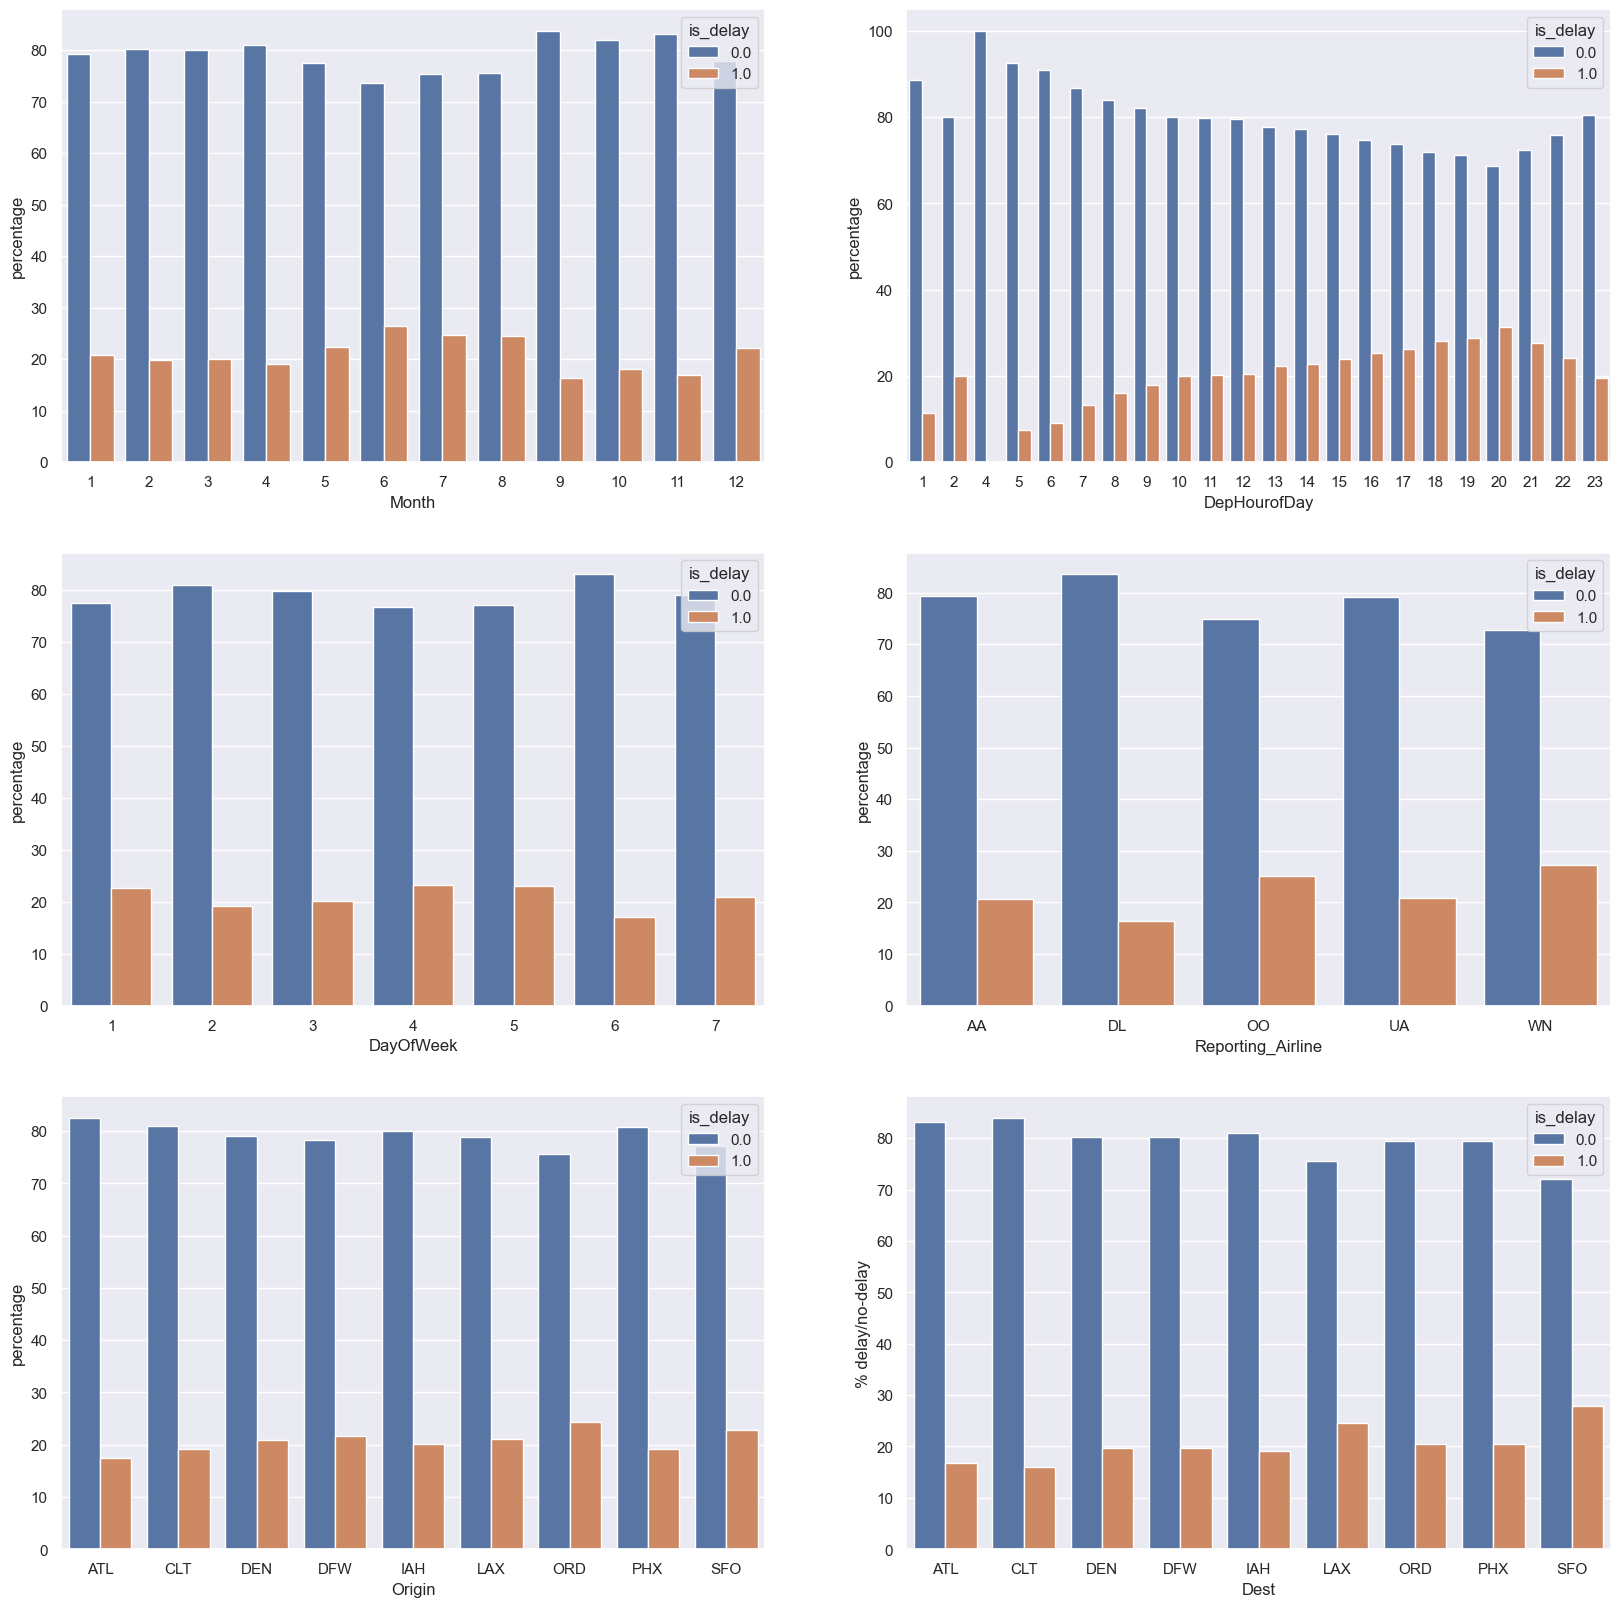

In [20]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

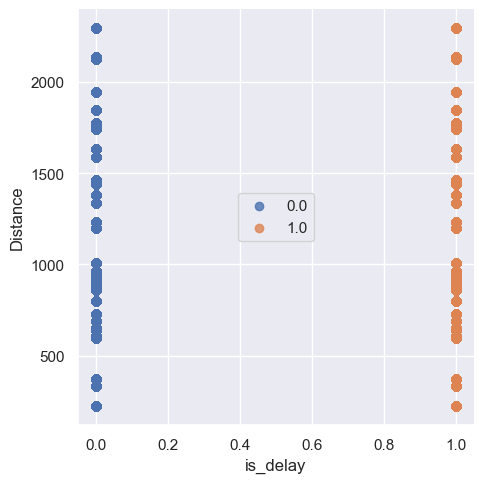

In [21]:
sns.lmplot(x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

### Features

Look at all the columns and what their specific types are.

In [22]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'labl_isdelay'],
      dtype='object')

In [23]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           Int64
labl_isdelay          object
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [24]:
# https://towardsdatascience.com/all-you-need-to-know-about-pandas-cut-and-qcut-functions-4a0c1001c38b
# https://datascience.stackexchange.com/questions/45118/cutting-numbers-into-fixed-buckets#:~:text=Assign%20to%20buckets,sort%20data%20values%20into%20bins.
bins = [0,4,8,12,16,20,24]
labls = ["first","second","third","fourth","fifth","sixth"]

data['DepHourofDay'] = pd.cut(data.DepHourofDay, bins = bins, labels = labls)

In [25]:
# https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
data_orig = data.copy()

# save the data frame "data_orig"
data_orig.to_csv("data_orig.csv", index = False, encoding = 'utf-8')

data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]

categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
       
for c in categorical_columns:
    data[c] = data[c].astype('category')

# data type of each column
data.dtypes

is_delay              float64
Quarter              category
Month                category
DayofMonth           category
DayOfWeek            category
Reporting_Airline    category
Origin               category
Dest                 category
Distance              float64
DepHourofDay         category
dtype: object

In [26]:
data['is_delay'] = data['is_delay'].astype('bool')

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

The one-hot encoding method is not suitable in this scenario, as too many categorical variables have been selected. In addition, some variables contain too many categorical features. Using the one-hot encoding method will create multiple dummy variables in the dataset without adding much information. Other drawbacks of the one-hot encoding method are creating a dummy variable trap and being computationally expensive. Binary encoding is a combination of hash encoding and one-hot encoding. Therefore, choosing the binary encoding method can reduce the curse of dimensionality of high cardinality data.

In [27]:
# https://analyticsindiamag.com/a-complete-guide-to-categorical-data-encoding/
# https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
# https://towardsdatascience.com/4-categorical-encoding-concepts-to-know-for-data-scientists-e144851c6383
# https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

import category_encoders as ce

encoder = ce.BinaryEncoder(cols=categorical_columns,return_df=True)

data_encoded = encoder.fit_transform(data)

Check the length of the dataset and the new columns.

In [28]:
# length of the data set
# rows
print("Number of rows in the dataset:",len(data_encoded))
# columns
print("Number of columns in the dataset:",len(data_encoded.columns))

Number of rows in the dataset: 1635590
Number of columns in the dataset: 31


Check the name of columns of the dataset "data_encoded".

In [29]:
data_encoded.columns

Index(['is_delay', 'Quarter_0', 'Quarter_1', 'Quarter_2', 'Month_0', 'Month_1',
       'Month_2', 'Month_3', 'DayofMonth_0', 'DayofMonth_1', 'DayofMonth_2',
       'DayofMonth_3', 'DayofMonth_4', 'DayOfWeek_0', 'DayOfWeek_1',
       'DayOfWeek_2', 'Reporting_Airline_0', 'Reporting_Airline_1',
       'Reporting_Airline_2', 'Origin_0', 'Origin_1', 'Origin_2', 'Origin_3',
       'Dest_0', 'Dest_1', 'Dest_2', 'Dest_3', 'Distance', 'DepHourofDay_0',
       'DepHourofDay_1', 'DepHourofDay_2'],
      dtype='object')

In [30]:
data_encoded.dtypes

is_delay                  bool
Quarter_0                int64
Quarter_1                int64
Quarter_2                int64
Month_0                  int64
Month_1                  int64
Month_2                  int64
Month_3                  int64
DayofMonth_0             int64
DayofMonth_1             int64
DayofMonth_2             int64
DayofMonth_3             int64
DayofMonth_4             int64
DayOfWeek_0              int64
DayOfWeek_1              int64
DayOfWeek_2              int64
Reporting_Airline_0      int64
Reporting_Airline_1      int64
Reporting_Airline_2      int64
Origin_0                 int64
Origin_1                 int64
Origin_2                 int64
Origin_3                 int64
Dest_0                   int64
Dest_1                   int64
Dest_2                   int64
Dest_3                   int64
Distance               float64
DepHourofDay_0           int64
DepHourofDay_1           int64
DepHourofDay_2           int64
dtype: object

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [31]:
data_encoded.rename(columns = {'is_delay':'target'}, inplace=True)

In [32]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B
data_encoded.to_csv('combined_csv_v1.csv', index = False, encoding='utf-8')

### Read the dataset

In [33]:
data_modeling = pd.read_csv('combined_csv_v1.csv')

In [34]:
data_modeling.head(5)

target  Quarter_0  Quarter_1  Quarter_2  Month_0  Month_1  Month_2  \
0   False          0          0          1        0        0        0   
1   False          0          0          1        0        0        0   
2   False          0          0          1        0        0        0   
3   False          0          0          1        0        0        0   
4   False          0          0          1        0        0        0   

   Month_3  DayofMonth_0  DayofMonth_1  ...  Origin_2  Origin_3  Dest_0  \
0        1             0             0  ...         0         1       0   
1        1             0             0  ...         1         0       0   
2        1             0             0  ...         0         1       0   
3        1             0             0  ...         0         1       0   
4        1             0             0  ...         1         1       0   

   Dest_1  Dest_2  Dest_3  Distance  DepHourofDay_0  DepHourofDay_1  \
0       0       0       1     689.0               1               1   
1       0       1       0     731.0               0               1   
2       0       1       1    1199.0               1               0   
3       1       0       0    1587.0               1               0   
4       0       1       0    1587.0               0               1   

   DepHourofDay_2  
0               0  
1               1  
2               1  
3               0  
4               0  

[5 rows x 31 columns]

### Train test split

In [35]:
# https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

'''
Alternative method (sample):

from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'SalePrice', 
                                                                            method='sorted', sort_by_col='saledate',
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)
'''
# write Code here to split data into train, validate and test
# split X and y into training and testing datasets
from sklearn.model_selection import train_test_split

X = data_modeling.drop(columns = ['target']).copy()

y = data_modeling['target']

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = True) 

In [36]:
data_modeling.columns

Index(['target', 'Quarter_0', 'Quarter_1', 'Quarter_2', 'Month_0', 'Month_1',
       'Month_2', 'Month_3', 'DayofMonth_0', 'DayofMonth_1', 'DayofMonth_2',
       'DayofMonth_3', 'DayofMonth_4', 'DayOfWeek_0', 'DayOfWeek_1',
       'DayOfWeek_2', 'Reporting_Airline_0', 'Reporting_Airline_1',
       'Reporting_Airline_2', 'Origin_0', 'Origin_1', 'Origin_2', 'Origin_3',
       'Dest_0', 'Dest_1', 'Dest_2', 'Dest_3', 'Distance', 'DepHourofDay_0',
       'DepHourofDay_1', 'DepHourofDay_2'],
      dtype='object')

In [37]:
X_train_data.head(5)

Quarter_0  Quarter_1  Quarter_2  Month_0  Month_1  Month_2  Month_3  \
1350011          0          1          0        0        0        1        0   
877477           1          0          0        1        0        1        0   
1113872          0          0          1        0        1        1        0   
1382185          0          1          0        0        1        0        0   
1221680          1          0          0        1        0        1        0   

         DayofMonth_0  DayofMonth_1  DayofMonth_2  ...  Origin_2  Origin_3  \
1350011             1             1             0  ...         0         0   
877477              0             0             0  ...         0         0   
1113872             0             1             0  ...         1         1   
1382185             0             0             1  ...         1         1   
1221680             0             0             1  ...         0         0   

         Dest_0  Dest_1  Dest_2  Dest_3  Distance  DepHourofDay_0  \
1350011       1       0       0       0     967.0               1   
877477        0       1       1       0     862.0               1   
1113872       1       0       0       1    1846.0               1   
1382185       0       0       1       0    2139.0               0   
1221680       0       1       0       0     370.0               1   

         DepHourofDay_1  DepHourofDay_2  
1350011               0               0  
877477                0               1  
1113872               1               0  
1382185               1               1  
1221680               1               0  

[5 rows x 30 columns]

### Baseline classification model

In [38]:
from sklearn.linear_model import LogisticRegression
model_base = LogisticRegression(solver='liblinear',C = 10)

# fit the model with the training data
model_base.fit(X_train_data, y_train_data)

LogisticRegression(C=10, solver='liblinear')

In [39]:
# prediction results
y_base_pred = model_base.predict(X_test_data)

In [40]:
data_modeling["target"].unique()

array([False,  True])

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [41]:
# https://akashmittal.com/code-example-what-is-confusionmatrixdisplay-in-scikit-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
# https://www.tutorialspoint.com/how-to-hide-axes-and-gridlines-in-matplotlib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrx(test_labels, target_predicted, labls):
    confusn_matx = confusion_matrix(test_labels,target_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix = confusn_matx, display_labels = labls)
    disp.plot()
    plt.grid(False)
    plt.show()

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc(test_labels, pred_prob_test, train_labels, pred_prob_train):
    test_fpr, test_tpr, thresholds = roc_curve(test_labels, pred_prob_test)
    train_fpr, train_tpr, thresholds = roc_curve(train_labels, pred_prob_train)

    plt.figure(figsize=(10,8))
    plt.plot(train_fpr, train_tpr, '-g', label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, ':r', label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1], [0,1], 'k--' )
    plt.title('ROC Curve')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid()
    plt.show()

In [43]:
# statistics
# https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.sensitivity_score.html
# https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.specificity_score.html
from sklearn import metrics
import imblearn

print("Accuracy:",metrics.accuracy_score(y_test_data,y_base_pred))
print("Precision:",metrics.precision_score(y_test_data,y_base_pred, average ='weighted'))
print("Recall:",metrics.recall_score(y_test_data,y_base_pred, average = 'weighted'))
# print("sensitivity:",imblearn.metrics.sensitivity_score(y_test_data,y_base_pred,average = 'weighted')) # tp / (tp + fn)
print("specificity:",imblearn.metrics.specificity_score(y_test_data,y_base_pred,average = 'weighted')) # tn / (tn + fp)
print("F1-score:",metrics.f1_score(y_test_data,y_base_pred, average = 'weighted'),"\n")

Accuracy: 0.7900237834665167
Precision: 0.7472494078139011
Recall: 0.7900237834665167
specificity: 0.2103782718224086
F1-score: 0.6975211109638053 



To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

In [44]:
confusion_matrix(y_test_data,y_base_pred)

array([[258397,     24],
       [ 68663,     34]], dtype=int64)

In [45]:
plot_confusion_matrx(y_test_data,y_base_pred,["No delay", "Delay"])

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

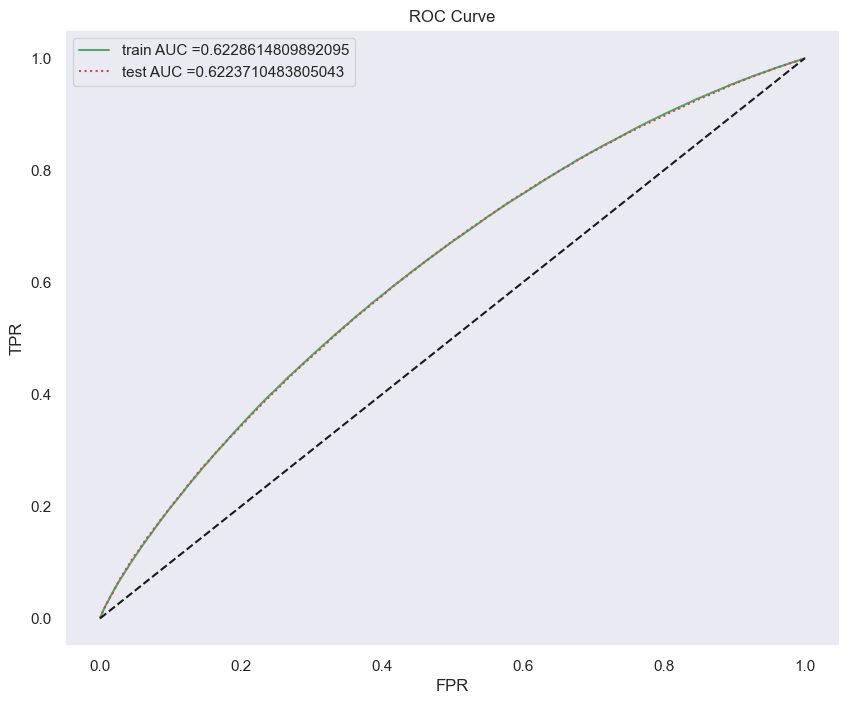

In [46]:
# https://www.statology.org/plot-roc-curve-python/
# https://stackoverflow.com/questions/16815928/what-does-mean-on-numpy-arrays
y_pred_logreg_proba = model_base.predict_proba(X_test_data)
y_train_logreg_proba = model_base.predict_proba(X_train_data)

plot_roc(y_test_data,y_pred_logreg_proba[::,1],y_train_data, y_train_logreg_proba[::,1])

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

1. The model's AUC score of the test set is almost the same as that of the training set. Hence, the model performs similarly on both training and testing sets.

2. The model's accuracy and recall are about 80%, suggesting that the model works well when making overall predictions. However, the model's F1-Score is lower, at 70 per cent, which was caused by the mislabelling of undelayed flights. That's also why specificity is extremely lower than other metrics, at only 21 per cent.

3. From a business standpoint, specificity is the most important metric since it implies the correct prediction of negative labels, i.e., delayed flights. Passengers usually feel anxious and disappointed about flight delays.




**Question**: What can you summarize from the confusion matrix?


The confusion matrix suggests that many delayed flights were mislabelled as undelayed flights (represented by False Positive), despite the model making a good prediction on undelayed flights. Hence, the model does not work in the real business scenario, as the company cares about the correct prediction of delayed flights. The business scenario is similar to ATO's audit scenario, where commissioners want to identify taxpayers requiring audit and review correctly.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


### Provide a link for your Gitlab repository here

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [47]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

data_orig = pd.read_csv("data_orig.csv")

In [48]:
# https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
# https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
data_orig['is_holiday'] = np.where(data_orig['FlightDate'].isin(holidays), True, False)

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [49]:
from smart_open import open 
with open('daily-summaries.csv', 'w') as fout: 
   for line in open('https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31', 'r'): 
      fout.write(line)

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [50]:
weather = pd.read_csv('daily-summaries.csv')

weather.head()

STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0

In [51]:
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
station_map = {station[i]: airports[i] for i in range(len(station))}
weather['airport'] = weather['STATION'].map(station_map) 

In [52]:
weather.head()

STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport  
0     LAX  
1     LAX  
2     LAX  
3     LAX  
4     LAX

Create another column called `MONTH` from the `DATE` column.

In [53]:
# https://stackoverflow.com/questions/31737939/split-pandas-column-into-two
# https://www.w3schools.com/python/ref_string_split.asphttps://www.w3schools.com/python/ref_string_split.asphttps://www.w3schools.com/python/ref_string_split.asphttps://www.w3schools.com/python/ref_string_split.asphttps://www.w3schools.com/python/ref_string_split.asphttps://www.w3schools.com/python/ref_string_split.asphttps://www.w3schools.com/python/ref_string_split.asp
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])
weather.head()

STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport MONTH  
0     LAX    01  
1     LAX    01  
2     LAX    01  
3     LAX    01  
4     LAX    01

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [54]:
# https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
weather.SNOW.fillna(0, inplace=True)
weather.SNWD.fillna(0, inplace=True)
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [55]:
TAVG_idx = np.where(weather['TAVG'].isnull())[0] 
TMAX_idx = np.where(weather['TMAX'].isnull())[0]
TMIN_idx = np.where(weather['TMIN'].isnull())[0]

In [56]:
print(TAVG_idx)
print(TMAX_idx)
print(TMIN_idx)

[ 3956  3957  3958  3959  3960  3961  3962  3963  3964  3965  3966  3967
  3968  3969  3970  3971  3972  3973  3974  3975  3976  3977  3978  3979
  3980  3981  3982  3983  3984  3985  4017  4018  4019  4020  4021  4022
  4023  4024  4025  4026  4027  4028  4029  4030  4031  4032  4033  4034
  4035  4036  4037  4038  4039  4040  4041  4042  4043  4044  4045  4046
  4047 13420]
[10763 10764 10765 10766 10767 10768 10769 10770 10771 10772 10773 10774
 10775 10776 10777 10778 10779 10780 10781 10782]
[10763 10764 10765 10766 10767 10768 10769 10770 10771 10772 10773 10774
 10775 10776 10777 10778 10779 10780 10781 10782]


### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [57]:
weather_impute = weather.groupby(['MONTH','STATION']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

MONTH      STATION       TAVG        TMAX       TMIN
0    01  USW00003017  -2.741935   74.000000 -69.858065
1    01  USW00003927  79.529032  143.767742  20.696774

Merge the mean data with the weather data.

In [58]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [59]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [60]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [61]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [62]:
sum(data_orig.isna().any())

1

In [63]:
data_orig.isna().sum()

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay                 0
ArrDelayMinutes          0
is_delay                 0
AirTime                  0
DepHourofDay         16233
labl_isdelay             0
is_holiday               0
AWND_O                   0
PRCP_O                   0
SNOW_O                   0
TAVG_O                   0
AWND_D                   0
PRCP_D                   0
SNOW_D                   0
TAVG_D                   0
dtype: int64

In [64]:
# https://datatofish.com/rows-with-nan-pandas-dataframe/
data_orig[data_orig.isnull().any(axis=1)]

Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate  \
37       2014        1      1          24          5  2014-01-24   
130      2014        1      1          27          1  2014-01-27   
190      2014        1      1          26          7  2014-01-26   
632      2014        1      1           6          1  2014-01-06   
655      2014        1      1           6          1  2014-01-06   
...       ...      ...    ...         ...        ...         ...   
1633682  2018        3      9          17          1  2018-09-17   
1633906  2018        3      9          16          7  2018-09-16   
1633907  2018        3      9          16          7  2018-09-16   
1633969  2018        3      9          16          7  2018-09-16   
1634070  2018        3      9          15          6  2018-09-15   

        Reporting_Airline Origin OriginState Dest  ... labl_isdelay  \
37                     DL    PHX          AZ  ATL  ...           No   
130                    DL    PHX          AZ  ATL  ...           No   
190                    DL    PHX          AZ  ATL  ...           No   
632                    DL    DEN          CO  ATL  ...          Yes   
655                    DL    PHX          AZ  ATL  ...           No   
...                   ...    ...         ...  ...  ...          ...   
1633682                UA    SFO          CA  ORD  ...           No   
1633906                UA    SFO          CA  IAH  ...           No   
1633907                UA    SFO          CA  IAH  ...           No   
1633969                UA    SFO          CA  ORD  ...           No   
1634070                UA    LAX          CA  ORD  ...           No   

         is_holiday  AWND_O  PRCP_O  SNOW_O  TAVG_O  AWND_D  PRCP_D  SNOW_D  \
37            False      46       0     0.0   177.0      34       0     0.0   
130           False      25       0     0.0   176.0      46       0     0.0   
190           False      20       0     0.0   165.0      33       0     0.0   
632           False      45       0     0.0  -153.0      92      13     0.0   
655           False      17       0     0.0   120.0      92      13     0.0   
...             ...     ...     ...     ...     ...     ...     ...     ...   
1633682       False      63       0     0.0   159.0      15       0     0.0   
1633906       False      65       0     0.0   156.0      11       0     0.0   
1633907       False      65       0     0.0   156.0      11       0     0.0   
1633969       False      65       0     0.0   156.0      29       0     0.0   
1634070       False      31       0     0.0   221.0      31       0     0.0   

         TAVG_D  
37        -51.0  
130       106.0  
190        54.0  
632         6.0  
655         6.0  
...         ...  
1633682   261.0  
1633906   277.0  
1633907   277.0  
1633969   245.0  
1634070   231.0  

[16233 rows x 31 columns]

In [65]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'labl_isdelay', 'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [66]:
data_pre_new = data_orig.copy()
data_pre_new = data_pre_new[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                             'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
                             'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]

categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','DepHourofDay', 'is_holiday']
for c in categorical_columns:
    data_pre_new[c] = data_pre_new[c].astype('category')

In [67]:
data_pre_new = data_pre_new.dropna(subset=['DepHourofDay'])

In [68]:
data_pre_new.isna().sum()

is_delay             0
Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
Reporting_Airline    0
Origin               0
Dest                 0
Distance             0
DepHourofDay         0
is_holiday           0
AWND_O               0
PRCP_O               0
TAVG_O               0
AWND_D               0
PRCP_D               0
TAVG_D               0
SNOW_O               0
SNOW_D               0
dtype: int64

In [72]:
# https://analyticsindiamag.com/a-complete-guide-to-categorical-data-encoding/
# https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
# https://towardsdatascience.com/4-categorical-encoding-concepts-to-know-for-data-scientists-e144851c6383

import category_encoders as ce

encoder = ce.BinaryEncoder(cols=categorical_columns,return_df=True)

data_encoded_new = encoder.fit_transform(data_pre_new)

In [73]:
data_encoded_new.head(5)

is_delay  Year_0  Year_1  Year_2  Quarter_0  Quarter_1  Quarter_2  Month_0  \
0       0.0       0       0       1          0          0          1        0   
1       0.0       0       0       1          0          0          1        0   
2       0.0       0       0       1          0          0          1        0   
3       0.0       0       0       1          0          0          1        0   
4       0.0       0       0       1          0          0          1        0   

   Month_1  Month_2  ...  is_holiday_0  is_holiday_1  AWND_O  PRCP_O  TAVG_O  \
0        0        0  ...             0             1      33       0    54.0   
1        0        0  ...             0             1      39       0   136.0   
2        0        0  ...             0             1      33       0    54.0   
3        0        0  ...             0             1      33       0    54.0   
4        0        0  ...             0             1      20       0   165.0   

   AWND_D  PRCP_D  TAVG_D  SNOW_O  SNOW_D  
0      30       0   130.0     0.0     0.0  
1      33       0    54.0     0.0     0.0  
2      77       0    68.0     0.0     0.0  
3      20       0   165.0     0.0     0.0  
4      33       0    54.0     0.0     0.0  

[5 rows x 44 columns]

In [74]:
data_encoded_new.dtypes

is_delay               float64
Year_0                   int64
Year_1                   int64
Year_2                   int64
Quarter_0                int64
Quarter_1                int64
Quarter_2                int64
Month_0                  int64
Month_1                  int64
Month_2                  int64
Month_3                  int64
DayofMonth_0             int64
DayofMonth_1             int64
DayofMonth_2             int64
DayofMonth_3             int64
DayofMonth_4             int64
DayOfWeek_0              int64
DayOfWeek_1              int64
DayOfWeek_2              int64
Reporting_Airline_0      int64
Reporting_Airline_1      int64
Reporting_Airline_2      int64
Origin_0                 int64
Origin_1                 int64
Origin_2                 int64
Origin_3                 int64
Dest_0                   int64
Dest_1                   int64
Dest_2                   int64
Dest_3                   int64
Distance               float64
DepHourofDay_0           int64
DepHouro

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [75]:
data_encoded_new.columns

Index(['is_delay', 'Year_0', 'Year_1', 'Year_2', 'Quarter_0', 'Quarter_1',
       'Quarter_2', 'Month_0', 'Month_1', 'Month_2', 'Month_3', 'DayofMonth_0',
       'DayofMonth_1', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4',
       'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2', 'Reporting_Airline_0',
       'Reporting_Airline_1', 'Reporting_Airline_2', 'Origin_0', 'Origin_1',
       'Origin_2', 'Origin_3', 'Dest_0', 'Dest_1', 'Dest_2', 'Dest_3',
       'Distance', 'DepHourofDay_0', 'DepHourofDay_1', 'DepHourofDay_2',
       'is_holiday_0', 'is_holiday_1', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D'],
      dtype='object')

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [76]:
data_encoded_new.rename(columns = {'is_delay':'target'}, inplace=True)

In [77]:
data_encoded_new['target'] = data_encoded_new['target'].astype('bool')

In [78]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B
data_encoded_new.to_csv('combined_csv_v2.csv', index = False, encoding='utf-8')

In [79]:
data_encoded_new.head()

target  Year_0  Year_1  Year_2  Quarter_0  Quarter_1  Quarter_2  Month_0  \
0   False       0       0       1          0          0          1        0   
1   False       0       0       1          0          0          1        0   
2   False       0       0       1          0          0          1        0   
3   False       0       0       1          0          0          1        0   
4   False       0       0       1          0          0          1        0   

   Month_1  Month_2  ...  is_holiday_0  is_holiday_1  AWND_O  PRCP_O  TAVG_O  \
0        0        0  ...             0             1      33       0    54.0   
1        0        0  ...             0             1      39       0   136.0   
2        0        0  ...             0             1      33       0    54.0   
3        0        0  ...             0             1      33       0    54.0   
4        0        0  ...             0             1      20       0   165.0   

   AWND_D  PRCP_D  TAVG_D  SNOW_O  SNOW_D  
0      30       0   130.0     0.0     0.0  
1      33       0    54.0     0.0     0.0  
2      77       0    68.0     0.0     0.0  
3      20       0   165.0     0.0     0.0  
4      33       0    54.0     0.0     0.0  

[5 rows x 44 columns]

Create the training and testing sets again.

In [80]:
from sklearn.model_selection import train_test_split

X_new = data_encoded_new.drop(columns = ['target']).copy()

y_new = data_encoded_new['target']

X_train_data_new, X_test_data_new, y_train_data_new, y_test_data_new = train_test_split(X_new,y_new, test_size = 0.2, random_state = 42, shuffle = True) 

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [81]:
# Instantiate another logistic regression model
from sklearn.linear_model import LogisticRegression
model_base_new = LogisticRegression(solver='liblinear',C = 10)

# fit the model with the training data
model_base_new.fit(X_train_data_new, y_train_data_new)

# prediction results
y_base_pred_new = model_base_new.predict(X_test_data_new)

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrx(test_labels, target_predicted, labls):
    confusn_matx = confusion_matrix(test_labels,target_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix = confusn_matx, display_labels = labls)
    disp.plot()
    plt.grid(False)
    plt.show()

    
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc(test_labels, pred_prob_test, train_labels, pred_prob_train):
    test_fpr, test_tpr, thresholds = roc_curve(test_labels, pred_prob_test)
    train_fpr, train_tpr, thresholds = roc_curve(train_labels, pred_prob_train)

    plt.figure(figsize=(10,8))
    plt.plot(train_fpr, train_tpr, '-g', label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, ':r', label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1], [0,1], 'k--' )
    plt.title('ROC Curve')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid()
    plt.show()


In [83]:
from sklearn import metrics

import imblearn

print("Accuracy:",metrics.accuracy_score(y_test_data_new,y_base_pred_new))
print("Precision:",metrics.precision_score(y_test_data_new,y_base_pred_new, average ='weighted'))
print("Recall:",metrics.recall_score(y_test_data_new,y_base_pred_new, average = 'weighted'))
# print("sensitivity:",imblearn.metrics.sensitivity_score(y_test_data,y_base_pred,average = 'weighted')) # tp / (tp + fn)
print("specificity:",imblearn.metrics.specificity_score(y_test_data_new,y_base_pred_new,average = 'weighted')) # tn / (tn + fp)
print("F1-score:",metrics.f1_score(y_test_data_new,y_base_pred_new, average = 'weighted'),"\n")

Accuracy: 0.7906734759411126
Precision: 0.7396467675996046
Recall: 0.7906734759411126
specificity: 0.24013646400004862
F1-score: 0.712185876276496 



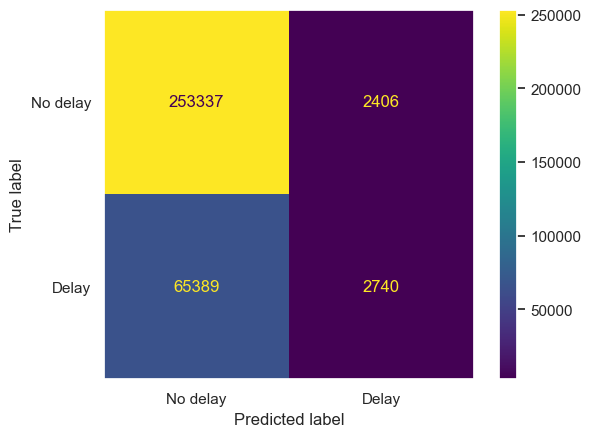

In [84]:
plot_confusion_matrx(y_test_data_new,y_base_pred_new,["No delay", "Delay"])

In [85]:
y_pred_logreg_proba_new = model_base_new.predict_proba(X_test_data_new)
y_train_logreg_proba_new = model_base_new.predict_proba(X_train_data_new)

plot_roc(y_test_data_new,y_pred_logreg_proba_new[::,1],y_train_data_new, y_train_logreg_proba_new[::,1])

Question: did you notice a difference by adding the extra data on the results?

The newly trained model has a much higher AUC score than the original model.


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

## Extra work for Tabelau

In [86]:
data_encoded_new_one_hot = pd.get_dummies(data_pre_new,columns=categorical_columns, drop_first=True)


data_encoded_new_one_hot.columns

Index(['is_delay', 'Distance', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015', 'Year_2016',
       'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOf

In [87]:
for col in data_encoded_new_one_hot.columns:
    print(col)

is_delay
Distance
AWND_O
PRCP_O
TAVG_O
AWND_D
PRCP_D
TAVG_D
SNOW_O
SNOW_D
Year_2015
Year_2016
Year_2017
Year_2018
Quarter_2
Quarter_3
Quarter_4
Month_2
Month_3
Month_4
Month_5
Month_6
Month_7
Month_8
Month_9
Month_10
Month_11
Month_12
DayofMonth_2
DayofMonth_3
DayofMonth_4
DayofMonth_5
DayofMonth_6
DayofMonth_7
DayofMonth_8
DayofMonth_9
DayofMonth_10
DayofMonth_11
DayofMonth_12
DayofMonth_13
DayofMonth_14
DayofMonth_15
DayofMonth_16
DayofMonth_17
DayofMonth_18
DayofMonth_19
DayofMonth_20
DayofMonth_21
DayofMonth_22
DayofMonth_23
DayofMonth_24
DayofMonth_25
DayofMonth_26
DayofMonth_27
DayofMonth_28
DayofMonth_29
DayofMonth_30
DayofMonth_31
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
Reporting_Airline_DL
Reporting_Airline_OO
Reporting_Airline_UA
Reporting_Airline_WN
Origin_CLT
Origin_DEN
Origin_DFW
Origin_IAH
Origin_LAX
Origin_ORD
Origin_PHX
Origin_SFO
Dest_CLT
Dest_DEN
Dest_DFW
Dest_IAH
Dest_LAX
Dest_ORD
Dest_PHX
Dest_SFO
DepHourofDay_first
DepHourofDay_fourt

In [88]:
data_encoded_new_one_hot.to_csv('combined_csv_v2_one_hot.csv', index = False, encoding='utf-8')

Tableau Dashboard

1. Number of flights by top 5 airlines in the U.S.
https://public.tableau.com/app/profile/xucheng.xie/viz/Numberofflightsbytop5airlinesfinalprojectof11523/Numberofflightsbyyear 

2. Fligt delays by months and departure hours
https://public.tableau.com/app/profile/xucheng.xie/viz/Flightdelaysbymonthsanddepaturehoursfinalprojectof11523/Flightdelaysbymonthsanddeparturehours

3. Flight delays in the U.S. by year
https://public.tableau.com/app/profile/xucheng.xie/viz/FlightdelaysintheU_S_byyearfinalprojectof11523/Flightdelaysbyyear





## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

1. The model still does not meet the business goal, as many delayed flights were continually mislabeled as undelayed flights, despite the improvement in specificity. The specificity is about 24 per cent, slightly higher than the original model's, and it suggests that 1 out of 4 delayed flights were correctly labelled. In the future, feature selection (especially for categorical variables, which can be tested using the chi-squared method) will be desirable to improve the model's accuracy. Even though the binary encoding method has been applied, the model has too many variables and experiences overfitting issues. 

2. The new model's AUC score is 5 per cent higher than the original model's. In addition to merging two datasets to add more variables, the binary encoding method is another technique in data wrangling. Some variables are not suitable for using the one-hot encoding method, for example, the date of a month, where 30 dummy variables were created.

3. The biggest challenge is the high requirement of computational power. The CSV file size is much bigger when using the one-hot encoding method on categorical variables without any further pre-processing (bucketing) and outputting the data frame to a CSV file. Additionally, there are some issues with the function "combine_csv", as it fails to filter rows based on given conditions. The variable "temp" should be replaced with "df_filter".

4. The first thing learned is the importance of feature selection. In addition to overfitting issues, including too many variables is computationally expensive. Second, encoding methods such as binary and hash encoding are more suitable when dealing with high-cardinality data. The third thing is that some other techniques, for example, hybrid models, could be applied n this scenario. We may first use PCA to reduce the data dimension, then use logistic regression or support vector machine to make predictions.


